This NB inject waveforms with prescribe amplitude (A) into LIGO noise timeseries, and calculate its SNR via the FindChirp algorithm.

Discussion: 
1) Shall we / How to inject signal with 'given' SNR ?

inject h(A) --> calculate SNR --> test sensitivity --> plot SNR/sensitivity (No need to inject signal with given SNR)


/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



len(hp=13299)


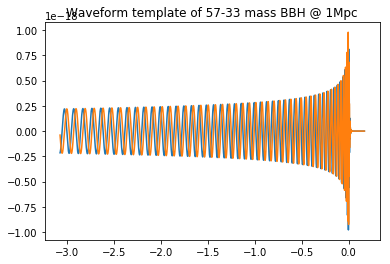

In [1]:
###  
### PyCBC waveform generator
###
#
#  First, let's generate a EOB waveform by PyCBC
#
###
from scipy.interpolate import interp1d
import pycbc.noise
import pycbc.psd
import pycbc.waveform
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import numpy as np

from scipy import signal
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

RATE = 4096
dt        = 1.0/RATE
apx       = 'SEOBNRv4'
f_low     = 10
m1 = 57
m2 = 33
hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
        mass1=m1, mass2=m2, spin1z=0, delta_t=dt, f_lower=f_low)
Nt = len(hp)
time = hp.sample_times

plt.plot(time, hp)
plt.plot(time, hc)
plt.title("Waveform template of %d-%d mass BBH @ 1Mpc"%(m1,m2))

print ("len(hp=%d)"%Nt)


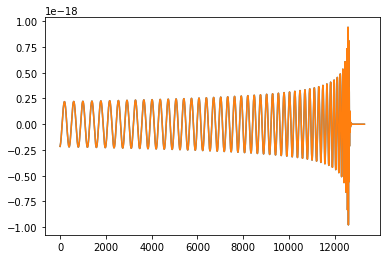

In [2]:
###
###  Here is the code snippet to comfirm the normalization constance of FFT/iFFT
###  Note the freedom in choicing the constant in both FFT/iFFT.
###  However, the ASD==np.sqrt(PSD) should be " np.fft.rfft(hp) * dt ".
###
plt.plot(hp)
freqs2 = np.fft.rfftfreq(Nt, dt)
#hf  = np.fft.rfft(hp)  / RATE
#hff = np.fft.irfft(hf) * RATE
hf  = np.fft.fft(hp)
hff = np.fft.ifft(hf)

#plt.plot(hff)
plt.plot(hp)


In [3]:
###
### Let's also check the frequency bin of FFT and rFFT
###

## N pts with dt, T=dt*(n-1)
npts=20
delta_t=0.1
T=delta_t*(npts)
a=np.fft.rfftfreq(npts, delta_t)
print a
print ("# pts: %d f_pts=%d dt=%f Fmax=%f, df=%f" %( npts, len(a), delta_t, 0.5/delta_t, 1./T))

## N pts with dt, T=dt*(n-1)
npts=20
delta_t=0.1
T=delta_t*(npts)
a=np.fft.fftfreq(npts, delta_t)
print a
print ("# pts: %d f_pts=%d dt=%f Fmax=%f, df=%f" %( npts, len(a), delta_t, 0.5/delta_t, 1./T))


[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
# pts: 20 f_pts=11 dt=0.100000 Fmax=5.000000, df=0.500000
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5 -5.  -4.5 -4.  -3.5
 -3.  -2.5 -2.  -1.5 -1.  -0.5]
# pts: 20 f_pts=20 dt=0.100000 Fmax=5.000000, df=0.500000


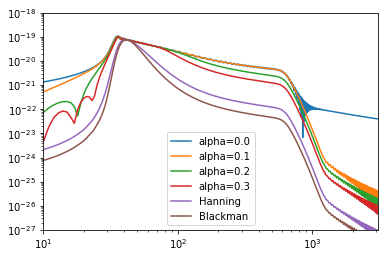

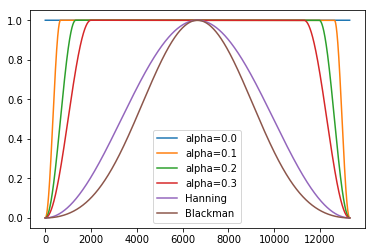

In [4]:
### [Box.1]
### Test windows function
### Window function is for minimize the spectrum leakage due to the aperiodicity, 
### which cause high-f artifects that smeared down to the Nyquest freq.
### As such, it alter high-f very much -- 0.1 tukey seems reasonable  !!!
if 1:
    plt.figure()
    for a in [0, 0.1, 0.2, 0.3]:
        dwindow = signal.tukey(Nt, alpha=a)
        hf = np.fft.rfft(hp*dwindow) *dt
        plt.loglog(np.abs(hf), label="alpha=%.1f"%a)
    dwindow = np.hanning(Nt)
    hf = np.fft.rfft(hp*dwindow) *dt
    plt.loglog(np.abs(hf), label="Hanning")
    dwindow = signal.blackman(Nt)
    hf = np.fft.rfft(hp*dwindow) *dt
    plt.loglog(np.abs(hf), label="Blackman")

    plt.xlim(10,3096)
    plt.ylim(1e-27,1e-18)
    plt.legend()
    plt.show()
    
    plt.figure()
    for a in [0, 0.1, 0.2, 0.3]:
        dwindow = signal.tukey(Nt, alpha=a)
        plt.plot(dwindow, label="alpha=%.1f"%a)
    dwindow = np.hanning(Nt)
    plt.plot(dwindow, label="Hanning")
    dwindow = signal.blackman(Nt)
    plt.plot(dwindow, label="Blackman")

    plt.legend()
    plt.show()

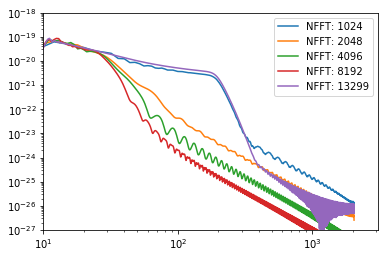

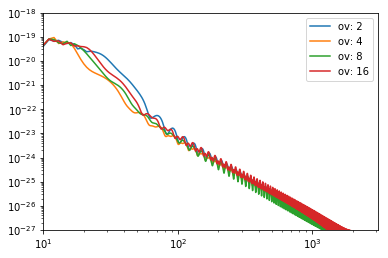

In [5]:
### [ Box.2 ]
### Test PSD NFFT, and noverlay

### Smaller NFFT, more high-pass !!
plt.figure()
for nfft in [RATE/4, RATE/2, RATE, RATE*2, Nt ]:
    hp_psd, hp_freqs = mlab.psd(hp, Fs = RATE, NFFT = nfft, noverlap=nfft/2, window=signal.tukey(nfft, alpha=0.1))
    
    plt.loglog(hp_freqs, np.sqrt(hp_psd),label="NFFT: %d"%nfft)
    plt.xlim(10,3096)
    plt.ylim(1e-27,1e-18)
plt.legend()
plt.show()

###
###  Overlap seems no effective !!?
###
plt.figure()
for ov in [2, 4, 8, 16]:
    NFFT=RATE
    hp_psd, hp_freqs = mlab.psd(hp, Fs = RATE, NFFT = NFFT, noverlap=NFFT/ov, window=signal.tukey(NFFT, alpha=0.1))
    
    plt.loglog(hp_freqs, np.sqrt(hp_psd), label="ov: %d"%ov)
    plt.xlim(10,3096)
    plt.ylim(1e-27,1e-18)
plt.legend()
plt.show()
    


1025


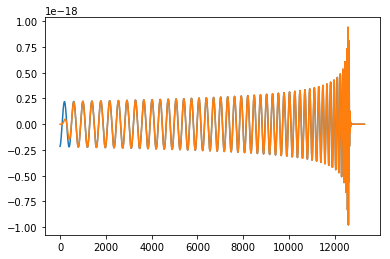

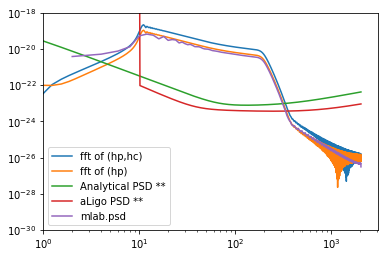

In [6]:
###
### Then, let's play around the LIGO PSD and GW template.
### Note that np.sqrt(PSD) ~ FFT.
### 
#
# Whiten GW template
#
def aLIGO_PSD(flow = 10.0, FMAX=8000, delta_f = 1./32., SEED=None):
    flen = int(FMAX / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
    return psd

def aLIGO_PSD_inp(flow = 10.0, FMAX=8000, delta_f = 1./16., SEED=None):
    flen = int(FMAX / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
    #psd = pycbc.psd.analytical.aLIGOZeroDetHighPower(flen, delta_f, flow)
    freqs = psd.sample_frequencies
        
    ## have to tweak the data to avoid 1/0 problem
    sel = np.where( psd.data<1.e-60 )
    psd.data[sel] = 1
        
    psd_interp = interp1d(freqs, psd)

    if 0:
        plt.loglog(freqs, np.sqrt(psd) )
        plt.show()
    
    return psd_interp

def LIGO_PSD_inp(FMAX=8192, delta_f = 1./16.):
    flen = int(FMAX / delta_f) + 1
    freqs = np.linspace(0,FMAX,flen)
    Pxx = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    
    psd_interp = interp1d(freqs, Pxx)
    return psd_interp

from scipy import signal

###
### using mlab.psd
### 
###
NFFT=RATE/2
hp_psd, hp_freqs = mlab.psd(hp, Fs = RATE, NFFT = NFFT, noverlap=NFFT/8, window=signal.tukey(NFFT, alpha=0.1))

print len(hp_freqs)

### using FFT
#dwindow = np.blackman(Nt)    ## this will remove all merging part !!
dwindow = signal.tukey(Nt, alpha=0.1)
f_hf = np.fft.rfftfreq(Nt, dt)
hf = np.fft.rfft(hp*dwindow) *dt
if 1:
    plt.figure()    
    plt.plot(hp)
    plt.plot(hp*dwindow)
    plt.show()
    

### using complex FFT
f_template_fft = np.fft.fftfreq(Nt, dt)
template = (hp + hc*1.j)
dwindow = signal.tukey(Nt, alpha=0.1)
template_fft = np.fft.fft(template*dwindow) *dt

### Approximate and smoothed PSD for H1 during O1, with no lines.
psd_ligo  = LIGO_PSD_inp()(f_hf)

### aLIGO PSD
psd_aligo = aLIGO_PSD_inp()(f_hf)

###
plt.loglog(f_template_fft, np.abs(template_fft), label="fft of (hp,hc)" ) 
plt.loglog(f_hf, np.abs(hf), label="fft of (hp)")
plt.loglog(f_hf, np.sqrt(psd_ligo), label="Analytical PSD **" )
plt.loglog(f_hf, np.sqrt(psd_aligo), label="aLigo PSD **" )
plt.loglog(hp_freqs, np.sqrt(hp_psd), label="mlab.psd")
plt.xlim(1,3096)
plt.ylim(1e-30,1e-18)
plt.legend()

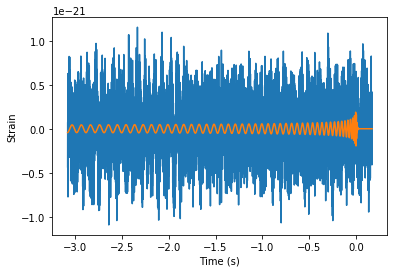

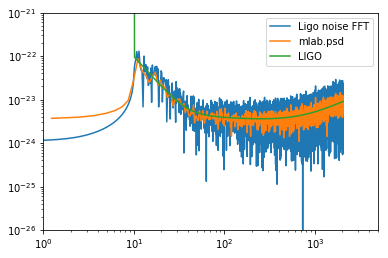

In [7]:
####
####   Now, let's generate noise from LIGO PSD, and calculate the noise PSD compared to the orinigal one.
####
import pycbc.noise
import pycbc.psd
import pylab

# The color of the noise matches a PSD which you provide
# let's start with (f_hf, psd_aligo) in the last cell.

# Generate noise
ligo_ns = pycbc.noise.noise_from_psd(Nt, dt, aLIGO_PSD(), seed=None)

#pylab.plot(ligo_ns.sample_times, ligo_ns, label="aLIGO noise")
#pylab.plot(time, hp/1000, label="waveform/1000")
pylab.plot(time,ligo_ns, label="aLIGO noise")
pylab.plot(time,hp/5000, label="waveform/5000")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

### FFT the generated noise
ligo_ns_fft = np.fft.rfft(ligo_ns) *dt   ### It is strange that rfft produce complex numbers.    

### PSD
NFFT = Nt//4
ligo_ns_psd, f_ligo_ns = mlab.psd(ligo_ns, Fs = RATE, NFFT = NFFT, noverlap=NFFT//8 , window=signal.tukey(NFFT, alpha=0.1))

pylab.loglog(f_hf, np.abs(ligo_ns_fft), label="Ligo noise FFT")
pylab.loglog(f_ligo_ns, np.sqrt(ligo_ns_psd), label="mlab.psd")
pylab.loglog(f_hf, np.sqrt(psd_aligo), label="LIGO")
plt.xlim(1,5000)
plt.ylim(1e-26,1e-21)
plt.legend()
pylab.show()

Fmax, df:  2048 1.0
freqs from PSD:  2049 [0.000e+00 1.000e+00 2.000e+00 ... 2.046e+03 2.047e+03 2.048e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]


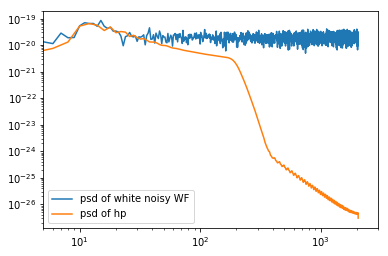

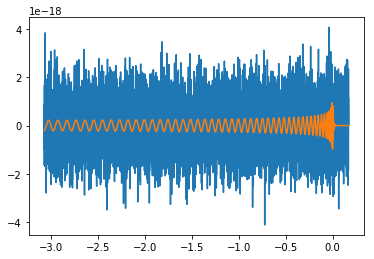

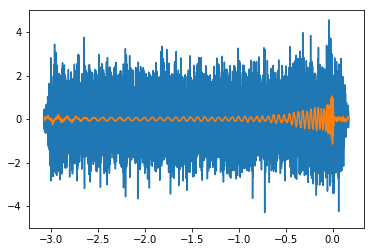

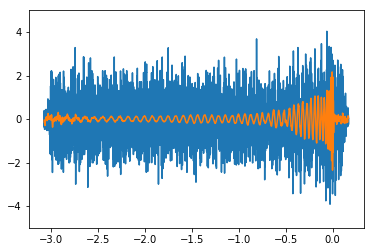

In [8]:
###
###  whitten a (template + gaussian noise) by its own PSD
###

from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

def whiten(strain, interp_psd, dt, bp=0):
    Nt = len(strain)
    f = np.fft.rfftfreq(Nt, dt)
    print len(f), f
    
    dwindow = signal.tukey(Nt, alpha=0.05)
    hf = np.fft.rfft(strain*dwindow)
    
    norm = np.sqrt(dt*2)
    white_hf = hf / np.sqrt(interp_psd(f)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    
    if bp:
        ## Bandpassing with 4th-order Butterworth D/A filter
        fband = [10.,500.]
        bb, ab = butter(4, [fband[0]*2./RATE, fband[1]*2./RATE], btype='band')
        normalization = np.sqrt((fband[1]-fband[0])/(RATE/2.0))
        white_ht = filtfilt(bb, ab, white_ht) / normalization
        
        if 0:  ## TODO
            plt.figure()
            w, h = signal.freqs(bb, ab)
            plt.plot(w, 20 * np.log10(abs(h)))
            plt.xscale('log')
            plt.title('Butterworth filter frequency response')
            plt.xlabel('Frequency [radians / second]')
            plt.ylabel('Amplitude [dB]')
            plt.margins(0, 0.1)
            plt.grid(which='both', axis='both')
            plt.axvline(100, color='green') # cutoff frequency
            plt.show()

    return white_ht
            
##
data = hp + 1*max(hp)*np.random.normal(0,1,Nt)
NFFT = RATE
Pxx, freqs = mlab.psd(data, Fs=RATE, NFFT=NFFT, noverlap=NFFT//8, window=signal.tukey(NFFT, alpha=0.1))
Pxx_inp = interp1d(freqs, Pxx)
print "Fmax, df: ", RATE/2, float(RATE)/NFFT 
print "freqs from PSD: ", len(freqs), freqs

###
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx), label="psd of white noisy WF")
plt.loglog(hp_freqs, np.sqrt(hp_psd), label="psd of hp")
plt.legend()
plt.xlim(5,3000)

##
whiten_data = whiten(data, Pxx_inp, dt, bp=0)
whiten_hp   = whiten(hp  , Pxx_inp, dt, bp=0)
whitenbp_data = whiten(data, Pxx_inp, dt, bp=1)
whitenbp_hp   = whiten(hp  , Pxx_inp, dt, bp=1)


plt.figure()
plt.plot(time, data)
plt.plot(time, hp)
plt.show()

plt.figure()
plt.plot(time, whiten_data)
plt.plot(time, whiten_hp)
plt.ylim(-5,5)
plt.show()

plt.figure()
plt.plot(time, whitenbp_data)
plt.plot(time, whitenbp_hp)
plt.ylim(-5,5)
plt.show()



Fmax, df:  2048 1.0


/usr/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]


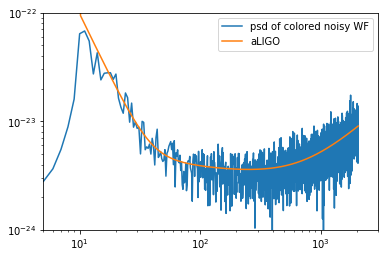

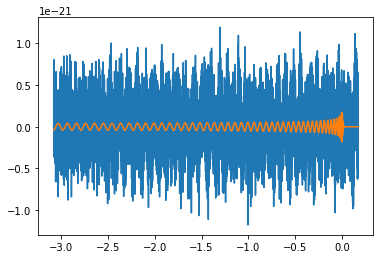

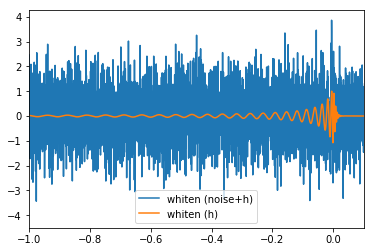

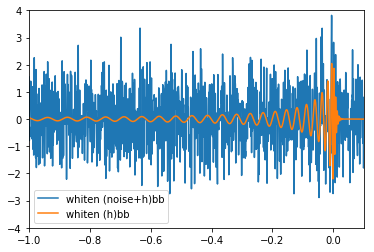

In [9]:
##
###  whitten a (template + LIGO gaussian noise) by its own/LIGO PSD. !!! THIS IS HOW HEURTA DOES THE TEST SET
##
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# Generate LIGO noise
ligo_ns = pycbc.noise.noise_from_psd(Nt, dt, aLIGO_PSD(), seed=None)

# Inject signal
h = 0.15 * hp.data *max(ligo_ns)/max(hp)
s = ligo_ns.data  + h

## PSD of data   ### NOTE: the choice NFFT affects very much on PSD
NFFT=RATE     
s_psd, f_s = mlab.psd(s, Fs = RATE, NFFT = NFFT, noverlap=NFFT/8, window=signal.tukey(NFFT, alpha=0.1) )

Pxx_inp = interp1d(f_s, s_psd)
print "Fmax, df: ", RATE/2, float(RATE)/NFFT 

###
plt.figure()
plt.loglog(f_s, np.sqrt(s_psd), label="psd of colored noisy WF")
plt.loglog(f_hf, np.sqrt(psd_aligo), label="aLIGO")
plt.legend()
plt.xlim(5,3000)
plt.ylim(1e-24,1e-22)

plt.figure()
plt.plot(time, s)
plt.plot(time, h)
plt.legend()

if 1:
    ## Whiten
    s_whiten   = whiten(s,  aLIGO_PSD_inp(), dt, bp=0)
    h_whiten   = whiten(h,  aLIGO_PSD_inp(), dt, bp=0)
    s_whitenbb = whiten(s,  aLIGO_PSD_inp(), dt, bp=1)
    h_whitenbb = whiten(h,  aLIGO_PSD_inp(), dt, bp=1)

    plt.figure()
    plt.plot(time, s_whiten, label="whiten (noise+h)")
    plt.plot(time, h_whiten, label="whiten (h)")
    plt.xlim(-1,0.1)
    plt.legend()
    plt.figure()
    plt.plot(time, s_whitenbb, label="whiten (noise+h)bb")
    plt.plot(time, h_whitenbb, label="whiten (h)bb")
    plt.xlim(-1,0.1)
    plt.ylim(-4,4)
    plt.legend()


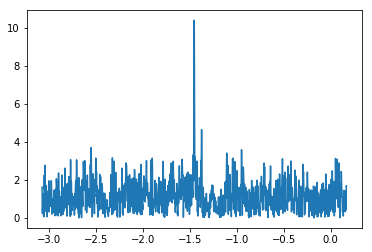

6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
6650 [0.00000000e+00 3.07993082e-01 6.15986164e-01 ... 2.04723002e+03
 2.04753801e+03 2.04784600e+03]
Maximum at -1.4541 with SNR = 10.4, D_eff = 5158.00, horizon = 6703.0 Mpc, Phase:-0.0940937000765
13299
13299
13299


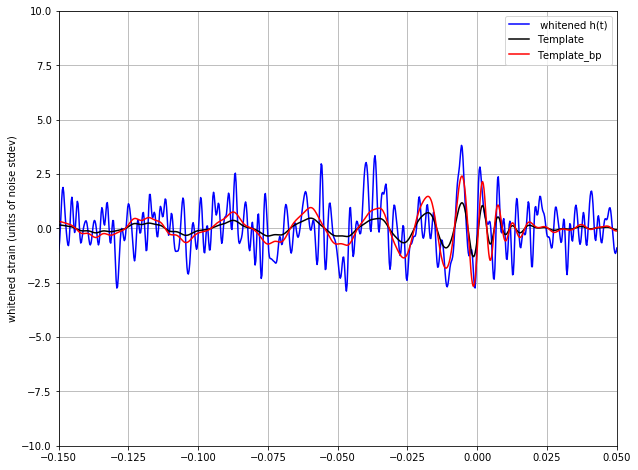

In [10]:
##
##  Next, calculate SNR
##
NFFT=RATE
s_psd, f_s = mlab.psd(s, Fs = RATE, NFFT = NFFT, noverlap=NFFT/8, window=signal.tukey(NFFT, alpha=0.1) )

###
### Template & windowed FFT : note that a rescaling of it doesn't change SNR. 
###
template = (hp + hc*1.j)
dwindow = signal.tukey(Nt, alpha=0.1)
template_fft = np.fft.fft(template*dwindow) *dt

s_fft = np.fft.fft(s*dwindow) *dt
sfreq = np.fft.fftfreq(Nt, dt)
df = np.abs(sfreq[1] - sfreq[0])

### 
###  Here, I can use either the analytical aLIGO PSD or PSD from the signal.
###
power_vec = np.interp(np.abs(sfreq), f_s, s_psd)
#power_vec = aLIGO_PSD_inp()( np.abs(sfreq) )

if 0:
    plt.figure()
    plt.loglog(np.abs(datafreq), np.sqrt(power_vec))
    plt.xlim(10,3000)
    plt.ylim(1e-25,1e-22)
    pylab.show()
    
optimal      = s_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal) *RATE

if 0:
    plt.figure()
    plt.plot(np.abs(s_fft))
    plt.show()

sigmasq = 1*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR_complex = optimal_time/sigma

###
### shift the SNR vector by the template length so that the peak is at the END of the template
###
peaksample = int(s.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

plt.figure()
plt.plot(time,SNR)
plt.show()

# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = hp.sample_times[indmax]
SNRmax = SNR[indmax]

#### Calculate the "effective distance" 
## The effective distance is related to the true distance by several geometrical factors that relate the source
## orientation to the detector orientation. 
d_eff = sigma / SNRmax
##  Calculate optimal horizon distnace --- the distance D for a NS-NS binary.
horizon = sigma/8     

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)

# apply time offset, phase, and d_eff to template 
template_phaseshifted = np.real( template.data*np.exp(1.j*phase) )    # phase shift the template
template_rolled = np.roll(template_phaseshifted, offset) / d_eff  # Apply time offset and scale amplitude

# Whiten and band-pass the template for plotting
template_match = whiten(template_rolled, interp1d(f_s, s_psd), dt, bp=0)
template_match_bp = whiten(template_rolled, interp1d(f_s, s_psd), dt, bp=1)

print('Maximum at {0:.4f} with SNR = {1:.1f}, D_eff = {2:.2f}, horizon = {3:0.1f} Mpc, Phase:{4}' 
      .format(timemax,SNRmax,d_eff,horizon, phase ))

if 1:
    print len(template.data)
    print len(template_rolled)
    print len(template_phaseshifted)

    plt.figure(figsize=(10,8))
    plt.plot(time,s_whitenbb     ,'b', label=' whitened h(t)')
    plt.plot(time,template_match,'k',label='Template')
    plt.plot(time,template_match_bp,'r',label='Template_bp')
    plt.ylim([-10,10])
    plt.xlim([-0.15,0.05])
    plt.grid('on')
    plt.legend()
    plt.ylabel('whitened strain (units of noise stdev)')



In [11]:
###
###  TODO --- Now, generate injection with given SNR
###

#ligo_ns = pycbc.noise.noise_from_psd(Nt, dt, aLIGO_PSD(), seed=None)

SNR=12.5

power_vec = aLIGO_PSD_inp()( np.abs(sfreq) )
sigmasq = (template_fft * template_fft.conjugate()  / power_vec).sum() * df
alpha = SNR / np.abs(sigmasq)**0.5 *RATE
print alpha


1.0553492464320102
